# Generate Novel Texts From Recurrent Neural Networks Based On Targeted Language Corpus of Philosophy from Stanford Encylopedia of Philosophy

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pandas as pd
import numpy as np
import json
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDiA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import metrics


In [3]:
from os import listdir
import re
import string
from nltk.corpus import stopwords
from collections import Counter
import numpy as np
import pandas as pd

In [4]:
###############################################################################
#Load all files extracted from Source
#Organize into sub categories for focus areas and remove any documents not aligning with 
#these top categories


corpus_directory = '////'

#Define classification groups for eventual classification analysis
#create 6 vocabulary sets for class divisions based on common vocab words
logic=['logic', 'logical', 'logics', 'syllogism', 'syllogisms', 'model']
mathematics=['mathematics','mathematical', 'number', 'set', 'sets', 'probability','probabilities', 'proof']
language=['language', 'linguistic', 'sentences', 'sentence', 'proposition', 'propositions', 'verb', 'verbs',
         'discourse', 'word', 'words']
mind=['cognition', 'cognitive', 'consciousness', 'thought', 'thoughts','knowledge', 'know', 'mental', 
        'perception', 'neural', 'brain', 'mind', 'selfknowledge']
phenomenology=['objects', 'object', 'truth', 'abstract', 'abstraction', 'phenomenal', 'phenomenology',
             'representation', 'representational', 'representations', 'experience', 'experiences']
ethics=['ethics', 'ethical', 'moral', 'morality', 'religion']

top_vocab=[]
def merge_list(group):
    for word in group:
        top_vocab.append(word)

merge_list(logic)
merge_list(mathematics)
merge_list(language)
merge_list(mind)
merge_list(phenomenology)
merge_list(ethics)
len(top_vocab)

#load individual corpus docs
#Create dict of entire corpus
#This will be used to process and align categories, top vocab terms with docs

def load_doc(filename):
    file=open(filename, 'r')
    text=file.read()
    file.close()
    return text    

def clean_doc(doc):
    tokens=doc.split()
    tokens=[word.lower() for word in tokens]
    re_punc=re.compile('[%s]'% re.escape(string.punctuation))
    tokens=[re_punc.sub('',w) for w in tokens]
    tokens=[word for word in tokens if word.isalpha()]
    stop_words=set(stopwords.words('english'))
    tokens=[word for word in tokens if not word in stop_words]
    tokens=[word for word in tokens if len(word)>2]
    return tokens

def process_docs(directory):
    for filename in listdir(directory):
        path=directory+'/'+filename
        doc=load_doc(path)
        tokens=clean_doc(doc)
        
        #process lists, counters, dicts:
        vocab.update(tokens)
        wordcount=Counter(tokens)
        corpus_dict_top5[filename]=wordcount.most_common(5)
        line= ' '.join(tokens)
        corpus_dict_sent[filename]=line
        vocab_tokens=[word for word in tokens if word in top_vocab]
        vocabcount=Counter(vocab_tokens)
        corpus_vdict[filename]=vocabcount

def save_list(lines, filename):
    data='\n'.join(lines)
    file=open(filename, 'w')
    file.write(data)
    file.close()

vocab=Counter()

#Top 5 words in each document for categorization
corpus_dict_top5={}
#Dict with top wordcounts for top vocab 6 group categorization list
corpus_vdict={}
#Dict with full length sentences
corpus_dict_sent={}

process_docs(corpus_directory)
print('starting corpus document size: ', len(corpus_dict_sent))

min_occurrence=50
vocab=[k for k,c in vocab.items() if c >= min_occurrence]
save_list(vocab, 'vocab.txt')
print('Full corpus filtered vocab size: %d' % len(vocab))


###############################################################################
#create subset of docs for class labels based on category specific vocabulary
#merge with main corpus to align docs with class labels
#concatenate word within category with corresponding usage frequency

def group_dfs(group):
    group_set={}
    for k,v in corpus_dict_top5.items():
        for name, count in v:
            if name in group:
                group_set[k]=v
    dkeys=[]
    dvals=[]
    for x,y in group_set.items():
        dkeys.append(x)
        dv=[]
        for item in y:
            dv.append(str(item[0]+'-'+str(item[1])))
        dvals.append(dv)
    headers=[]
    for x in range(1,6):
        label=str('word'+str(x))
        headers.append(label)
    newdf=pd.DataFrame(dvals, columns=headers, index=dkeys)
    return newdf

logic_df=group_dfs(logic)
mathematics_df=group_dfs(mathematics)
language_df=group_dfs(language)
mind_df=group_dfs(mind)
phenomenology_df=group_dfs(phenomenology)
ethics_df=group_dfs(ethics)

logic_df['class']='logic'
mathematics_df['class']='mathematics'
language_df['class']='language'
mind_df['class']='mind'
phenomenology_df['class']='phenomenology'
ethics_df['class']='ethics'

frames=[logic_df, mathematics_df, language_df, mind_df, phenomenology_df, ethics_df]
full_df=pd.concat(frames)
full_df=full_df.reset_index()
full_df=full_df.rename(columns={"index":"document"})
    
print('Docs categorized into groups based on top 5 words in lists:')
print(full_df['class'].value_counts())


#Some docs have vocabulary words from multiple lists
#Identify Dups, separate class assignment based on word list class
dups=full_df.duplicated(subset=['document'])
df_dup=pd.concat([full_df['document'], dups],axis=1, join='inner')
df_dup=df_dup.rename(columns={0:'duplicate'})
df_dup=df_dup[df_dup.duplicate]

duplist=df_dup.document.to_list()
uniquedocs=full_df[~full_df.document.isin(duplist)]
dupdocs=full_df[full_df.document.isin(duplist)]

print('full df shape with dups: ', full_df.shape)
print('unique docs shape: ', uniquedocs.shape)
print('dups docs shape: ', dupdocs.shape)
print('\nValue counts of unique doc classes:')
print(uniquedocs['class'].value_counts())

###############################################################################

#Clean duplicate docs based on first word assignment to category
#word that is top ranked in category is assigned to that category

docfilter=dupdocs.drop_duplicates(subset='document').copy(deep=True)
docfilter2=docfilter.copy(deep=True)
docfilter2[['word1w','word1c']]=docfilter2.word1.str.split("-",expand=True)

keepcols=['document','word1w']
primaryword=docfilter2.filter(items=keepcols, axis=1).copy(deep=True)

NaN=np.nan
primaryword['class']=NaN

def firstword(group, name):
    for i in range(len(primaryword)):
        for word in group:
            if primaryword.iloc[i,1]==word:
                primaryword.iloc[i,2]=name

firstword(logic, 'logic')
firstword(mathematics, 'mathematics')
firstword(language, 'language')
firstword(mind, 'mind')
firstword(phenomenology, 'phenomenology')
firstword(ethics, 'ethics')

primaryword.dropna(subset=['class'], inplace=True)
docfilter=docfilter.drop(columns=['class'])
uniquefiltered=pd.concat([docfilter, primaryword['class']],axis=1, join='inner')
print('additional unique filtered docs to include: ', uniquefiltered.shape)

frames=[uniquedocs, uniquefiltered]
final_corpus_df=pd.concat(frames)
print('final corpus shape: ', final_corpus_df.shape)
print('final corpus counts: \n')
print(uniquedocs['class'].value_counts())

starting corpus document size:  1029
Full corpus filtered vocab size: 2901
Docs categorized into groups based on top 5 words in lists:
mind             189
logic            139
phenomenology    135
language         128
mathematics       95
ethics            55
Name: class, dtype: int64
full df shape with dups:  (741, 7)
unique docs shape:  (482, 7)
dups docs shape:  (259, 7)

Value counts of unique doc classes:
mind             141
logic             84
phenomenology     75
language          72
mathematics       66
ethics            44
Name: class, dtype: int64
additional unique filtered docs to include:  (64, 7)
final corpus shape:  (546, 7)
final corpus counts: 

mind             141
logic             84
phenomenology     75
language          72
mathematics       66
ethics            44
Name: class, dtype: int64


# Categorize Documents Using LDiA for Analysis

In [5]:
#Load corpus files from json objects

with open('////json_texts_labels.json', 'r') as read_file:
    corpus_wLabels=json.load(read_file)
    
with open('////.json', 'r') as read_file:
    corpus_wTitles=json.load(read_file)
    
vocab_dir='////vocab.txt'
file=open(vocab_dir, 'r')
vocab=file.read()
file.close()
print('Number of documents in corpus: ', len(corpus_wLabels))

Number of documents in corpus:  546


In [6]:
#Load JSON Text Files

with open('////.json', 'r') as read_file:
    corpus_wTitles=json.load(read_file)
    
#Clean Data for Categorization
corp_text=list(corpus_wTitles.keys())
titles=list(corpus_wTitles.keys())

X_corp=[]
corp_words=Counter()

for text in corp_text:
    tokens=text.split()
    corp_words.update(tokens)
    wtokens=' '.join(tokens)
    X_corp.append(wtokens)

print('Full corpus filtered vocab size: %d' % len(corp_words))

Full corpus filtered vocab size: 1423


In [7]:
#Load lists of texts, titles, labels, categories
#remove additional stopwords with high occurrance but low value

corp_text=list(corpus_wLabels.keys())
labels=list(corpus_wLabels.values())
titles=list(corpus_wTitles.keys())
X_corp=[]
corp_words=Counter()

le=LabelEncoder()
y_labels=le.fit_transform(labels)

stopwords=['however','whether','even','may','given','one','also','way', 'every','simply','terms','kind','claim',
           'would','two','first','seems','seem','false','might','without','simple', 'like','see','view','example',
          'neutral', 'philosophy', 'philosophical', 'russell','whitehead', 'case','must','thus', 'bolzano']

for text in corp_text:
    tokens=text.split()
    tokens=[w for w in tokens if not w in stopwords]
    corp_words.update(tokens)
    wtokens=' '.join(tokens)
    X_corp.append(wtokens)

print('Full corpus filtered vocab size: %d' % len(corp_words))

Full corpus filtered vocab size: 23612


word matrix ldia shape:  (23612, 5)


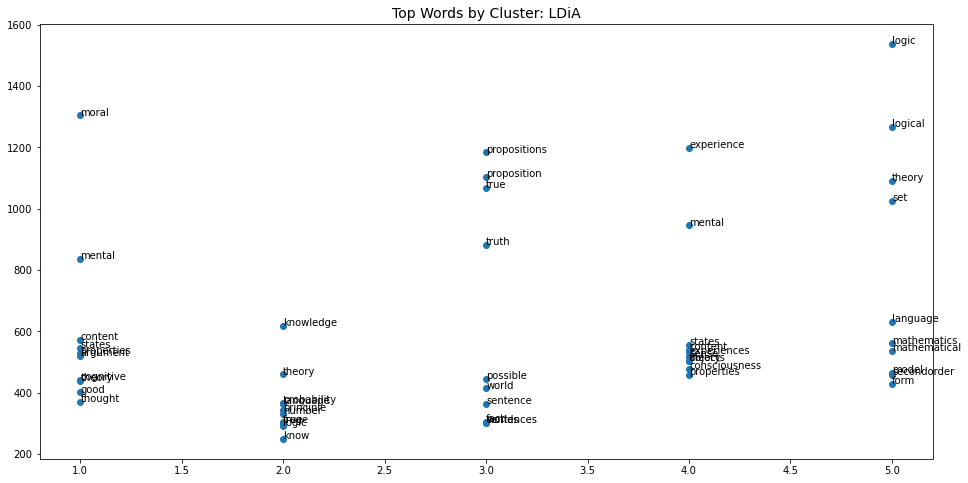

In [9]:
#LDiA

latent_vars=5

cv=CountVectorizer()
bow_docs=pd.DataFrame(cv.fit_transform(raw_documents=X_corp).toarray())
col_nums, terms=zip(*sorted(zip(cv.vocabulary_.values(),cv.vocabulary_.keys())))
bow_docs.columns=terms

ldia=LDiA(n_components=latent_vars, learning_method='batch', random_state=33)
ldia=ldia.fit(bow_docs)
ldia6_topic_vectors=ldia.transform(bow_docs)

columns=['topic'+str(x) for x in np.arange(1,latent_vars+1)]
ldia6_topic_vectors_df=pd.DataFrame(ldia.components_, columns=cv.get_feature_names()).T
print('word matrix ldia shape: ', ldia6_topic_vectors_df.shape)

ldia_vecs10={}
for col in ldia6_topic_vectors_df.columns:
    intldia=ldia6_topic_vectors_df.nlargest(10,col)
    ldia_vecs=list(zip(intldia.index.to_list(),intldia[col].to_list()))
    ldia_vecs10[col]=[ldia_vecs]

x,y,wlabel=[],[],[]
counter=0
for item in ldia_vecs10.values():
    counter=counter+1
    for word in item:
        for ww,wv in word:
            x.append(counter)
            y.append(wv)
            wlabel.append(ww)
            
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x, y)
for i, txt in enumerate(wlabel):
    ax.annotate(txt, (x[i], y[i]), fontsize=10)
plt.title('Top Words by Cluster: LDiA', fontsize=14)
plt.savefig('LDiA.png')

In [10]:
LDIA_df=pd.DataFrame(ldia6_topic_vectors, columns=['Ethics', 'Knowledge', 'Language','Cognition','Logic'])
LDIA_df['Title']=titles
LDIA_df['Category'] = LDIA_df[['Ethics', 'Knowledge', 'Language', 'Cognition', 'Logic']].idxmax(axis=1)
LDIA_df.head(5)

,Ethics,Knowledge,Language,Cognition,Logic,Title,Category
0,0.305189,0.077683,0.000259,0.616610,0.000259,Self Knowledge_1 The Distinctiveness of SelfKn...,Cognition
1,0.000339,0.000339,0.000338,0.998646,0.000338,Neutral Monism_1 Neutrality.txt,Cognition
2,0.000110,0.000109,0.235604,0.764069,0.000109,The Contents of Perception_3 Varieties of Cont...,Cognition
3,0.999629,0.000093,0.000093,0.000093,0.000092,Moral Cognitivism vs Non Cognitivism_3 Motiva...,Ethics
4,0.051730,0.384426,0.018728,0.544579,0.000537,Physicalism_14 The Case Against Physicalism I ...,Cognition


In [11]:
LDIA_df2=LDIA_df[['Title','Category']]
Logic_df = LDIA_df2[LDIA_df2['Category']=='Logic']
Logic_list=Logic_df.Title.tolist()

Ethics_df = LDIA_df2[LDIA_df2['Category']=='Ethics']
Ethics_list=Ethics_df.Title.tolist()

Knowledge_df = LDIA_df2[LDIA_df2['Category']=='Knowledge']
Knowledge_list=Knowledge_df.Title.tolist()

Cognition_df = LDIA_df2[LDIA_df2['Category']=='Cognition']
Cognition_list=Cognition_df.Title.tolist()

Language_df = LDIA_df2[LDIA_df2['Category']=='Language']
Language_list=Language_df.Title.tolist()

In [12]:
Logic,Ethics,Knowledge,Cognition,Language=[],[],[],[],[]

def load_doc(filename):
    file=open(filename, 'r')
    text=file.read()
    file.close()
    return text    

def clean_doc(doc):
    tokens=doc.split()
    tokens=[word.lower() for word in tokens]
    re_punc=re.compile('[%s]'% re.escape(string.punctuation))
    tokens=[re_punc.sub('',w) for w in tokens]
    tokens=[word for word in tokens if word.isalpha()]
    return tokens

def process_docs(directory, grouping, groupset):
    for filename in listdir(directory):
        if filename in grouping:
            path=directory+'/'+filename
            doc=load_doc(path)
            tokens=clean_doc(doc)
            for token in tokens:
                groupset.append(token)
    
corpus_directory = '/home/meeka/Desktop/NU/453/assn4/corpus'    
process_docs(corpus_directory, Logic_list, Logic)
process_docs(corpus_directory, Ethics_list, Ethics)
process_docs(corpus_directory, Knowledge_list, Knowledge)
process_docs(corpus_directory, Cognition_list, Cognition)
process_docs(corpus_directory, Language_list, Language)

In [13]:
def save_doc(lines, filename):
    data='\n'.join(lines)
    file=open(filename,'w')
    file.write(data)
    file.close()
    
length=50+1
sequences=list()
for i in range(length,len(Logic)):
    seq=Logic[i-length:i]
    line=' '.join(seq)
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))
out_filename='logic.txt'
save_doc(sequences, out_filename)

sequences=list()
for i in range(length,len(Ethics)):
    seq=Ethics[i-length:i]
    line=' '.join(seq)
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))
out_filename='ethics.txt'
save_doc(sequences, out_filename)

sequences=list()
for i in range(length,len(Knowledge)):
    seq=Knowledge[i-length:i]
    line=' '.join(seq)
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))
out_filename='knowledge.txt'
save_doc(sequences, out_filename)

sequences=list()
for i in range(length,len(Cognition)):
    seq=Cognition[i-length:i]
    line=' '.join(seq)
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))
out_filename='cognition.txt'
save_doc(sequences, out_filename)

sequences=list()
for i in range(length,len(Language)):
    seq=Language[i-length:i]
    line=' '.join(seq)
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))
out_filename='language.txt'
save_doc(sequences, out_filename)

Total Sequences: 250503
Total Sequences: 223055
Total Sequences: 185207
Total Sequences: 163379
Total Sequences: 133233


# Recurrent Neural Network Modeling

In [14]:
from numpy import array
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [19]:
def load_doc(filename):
    file=open(filename, 'r')
    text=file.read()
    file.close()
    return text

def define_model(vocab_size, seq_length):
    model=Sequential()
    model.add(Embedding(vocab_size, 50, input_length=seq_length))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(vocab_size, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model


In [20]:
in_filename='language.txt'

In [21]:
doc=load_doc(in_filename)
lines=doc.split('\n')

tokenizer=Tokenizer()
tokenizer.fit_on_texts(lines)
sequences=tokenizer.texts_to_sequences(lines)
vocab_size=len(tokenizer.word_index)+1

sequences=array(sequences)
X,y=sequences[:,:-1], sequences[:,-1]
y=to_categorical(y,num_classes=vocab_size)
seq_length=X.shape[1]

In [39]:
model=define_model(vocab_size, seq_length)
model.fit(X,y,batch_size=128, epochs=50)
model.save('Language_50.h5')
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            359950    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 7199)              727099    
Total params: 1,237,949
Trainable params: 1,237,949
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Epoch 1/50
1041/1041 [==

In [45]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences


def load_doc(filename):
    file=open(filename, 'r')
    text=file.read()
    file.close()
    return text

def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result=list()
    in_text=seed_text
    for _ in range(n_words):
        encoded=tokenizer.texts_to_sequences([in_text])[0]
        encoded=pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        yhat=model.predict_classes(encoded, verbose=0)
        out_word=''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        in_text+= ' ' + out_word
        result.append(out_word)
    return ' '.join(result)
    
    
in_filename='language.txt'
doc=load_doc(in_filename)

lines=doc.split('\n')
seq_length=len(lines[0].split())-1
model=load_model('Language_50.h5')
tokenizer=load(open('tokenizer.pkl', 'rb'))
seed_text=lines[randint(0,len(lines))]

print(seed_text + '\n')
generated=generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

of a thing is proof of its possibility while leibnizs principle of contradiction and principle of sufficient reason were discussed above it was not mentioned that these two principles are employed in the service of leibnizs distinction between truths of reasoning and truths of fact that is between necessary truths and

so represent the same proposition that is the same truth value and the proposition expressed by the proposition that socrates is wise is true at t at the level of sense in which the proposition is true if it is false that q is true at t at the level


# Additional Models

In [47]:
in_filename='cognition.txt'

doc=load_doc(in_filename)
lines=doc.split('\n')

tokenizer=Tokenizer()
tokenizer.fit_on_texts(lines)
sequences=tokenizer.texts_to_sequences(lines)
vocab_size=len(tokenizer.word_index)+1

sequences=array(sequences)
X,y=sequences[:,:-1], sequences[:,-1]
y=to_categorical(y,num_classes=vocab_size)
seq_length=X.shape[1]


model=define_model(vocab_size, seq_length)
model.fit(X,y,batch_size=128, epochs=50)
model.save('Cognition.h5')
dump(tokenizer, open('tokenizer.pkl', 'wb'))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 50)            424450    
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 8489)              857389    
Total params: 1,432,739
Trainable params: 1,432,739
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Epoch 1/50
1277/1277 [==

In [49]:
def load_doc(filename):
    file=open(filename, 'r')
    text=file.read()
    file.close()
    return text

def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result=list()
    in_text=seed_text
    for _ in range(n_words):
        encoded=tokenizer.texts_to_sequences([in_text])[0]
        encoded=pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        yhat=model.predict_classes(encoded, verbose=0)
        out_word=''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        in_text+= ' ' + out_word
        result.append(out_word)
    return ' '.join(result)
    
    
in_filename='language.txt'
doc=load_doc(in_filename)

lines=doc.split('\n')
seq_length=len(lines[0].split())-1
model=load_model('Cognition.h5')
tokenizer=load(open('tokenizer.pkl', 'rb'))
seed_text=lines[randint(0,len(lines))]

print(seed_text + '\n')
generated=generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

about a difficult type of dive that has never been performed thus while view appears to be a rejection of a traditional platonism about propositions it seems nevertheless to accept a platonism about types by untethering their existence from their tokens compare to defense of platonism about types soames also allows

for the subject valaris argues that the subject is not driven by representation let us be fully open the same as the same as the same as the internalist thesis that is the representationindependent fact to the inseparability of mental and the entry on the disjunctive theory of perception and
